In [18]:
# Suppress TensorFlow logs for cleaner output & ignore warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')

# Import all the libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, Dropout
from sklearn.metrics import classification_report, confusion_matrix

1. LSTM implementation

In [19]:
# Download stopwords
nltk.download('stopwords', download_dir='/kaggle/working/nltk_data')
nltk.data.path.append('/kaggle/working/nltk_data')
english_stops = set(stopwords.words('english'))

# Load dataset
train_data = pd.read_csv('phm_train.csv')  
test_data = pd.read_csv('phm_test.csv')    

# Preprocessing function
def load_dataset(data):
    x_data = data['tweet']
    y_data = data['label']

    # Remove HTML tags and non-alphabet characters
    x_data = x_data.replace({'<.*?>': ''}, regex=True)
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex=True)

    # Remove stopwords and convert to lowercase
    x_data = x_data.apply(lambda review: [w.lower() for w in review.split() if w.lower() not in english_stops])

    return x_data, y_data

x_train, y_train = load_dataset(train_data)
x_test, y_test = load_dataset(test_data)

# Convert Tokens to Text Strings
x_train = x_train.apply(lambda x: ' '.join(x))
x_test = x_test.apply(lambda x: ' '.join(x))

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_seq, maxlen=250, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=250, padding='post', truncating='post')

# Define the LSTM model
LSTM_model = Sequential()
LSTM_model.add(Embedding(input_dim=10000, output_dim=64))
LSTM_model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
LSTM_model.add(Dense(1, activation='sigmoid'))

# Compile LSTM_model
LSTM_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the LSTM_model
history_lstm = LSTM_model.fit(x_train_pad, y_train, epochs=10, batch_size=16, validation_data=(x_test_pad, y_test))

# Evaluate on test data
loss, accuracy = LSTM_model.evaluate(x_test_pad, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 190ms/step - accuracy: 0.6953 - loss: 0.6265 - val_accuracy: 0.7097 - val_loss: 0.6026
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 180ms/step - accuracy: 0.7180 - loss: 0.5966 - val_accuracy: 0.7097 - val_loss: 0.6026
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 107s 171ms/step - accuracy: 0.7125 - loss: 0.6016 - val_accuracy: 0.7097 - val_loss: 0.6025
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 91s 146ms/step - accuracy: 0.7118 - loss: 0.6027 - val_accuracy: 0.7097 - val_loss: 0.6039
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 150ms/step - accuracy: 0.7133 - loss: 0.6004 - val_accuracy: 0.7097 - val_loss: 0.6031
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 91s 146ms/step - accuracy: 0.7105 - loss: 0.6022 - val_accuracy: 0.7097 - val_loss: 0.6024
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 147ms/step - accuracy: 0.7122 - loss: 0.6023 - val_accuracy: 0.7097 - val_loss: 0.6025
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 149ms/step - accuracy: 0.7093 - loss

105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2364
           1       0.00      0.00      0.00       967

    accuracy                           0.71      3331
   macro avg       0.35      0.50      0.42      3331
weighted avg       0.50      0.71      0.59      3331




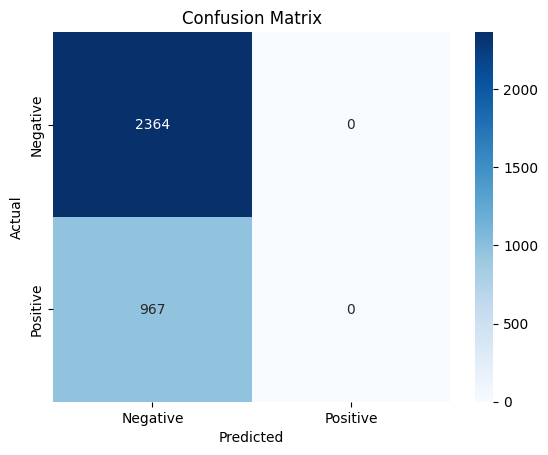

In [20]:
# Predict on test data
y_pred_probs = LSTM_model.predict(x_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels
print()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# LSTM Model Performance
train_acc_lstm = history_lstm.history['accuracy'][-1]
train_loss_lstm = history_lstm.history['loss'][-1]
val_acc_lstm = history_lstm.history['val_accuracy'][-1]
val_loss_lstm = history_lstm.history['val_loss'][-1]

print("\nLSTM Model Performance:")
print(f"Train Accuracy: {train_acc_lstm:.4f}")
print(f"Train Loss: {train_loss_lstm:.4f}")
print(f"Validation Accuracy: {val_acc_lstm:.4f}")
print(f"Validation Loss: {val_loss_lstm:.4f}")


LSTM Model Performance:
Train Accuracy: 0.7097
Train Loss: 0.6029
Validation Accuracy: 0.7097
Validation Loss: 0.6027


2. Bi-LSTM Implementation

In [27]:
# Download stopwords
nltk.download('stopwords', download_dir='/kaggle/working/nltk_data')
nltk.data.path.append('/kaggle/working/nltk_data')
english_stops = set(stopwords.words('english'))

# Load dataset
train_data = pd.read_csv('phm_train.csv')  
test_data = pd.read_csv('phm_test.csv')    

# Preprocessing function
def load_dataset(data):
    x_data = data['tweet']
    y_data = data['label']

    # Remove HTML tags and non-alphabet characters
    x_data = x_data.replace({'<.*?>': ''}, regex=True)
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex=True)

    # Remove stopwords and convert to lowercase
    x_data = x_data.apply(lambda review: [w.lower() for w in review.split() if w.lower() not in english_stops])

    return x_data, y_data

x_train, y_train = load_dataset(train_data)
x_test, y_test = load_dataset(test_data)

# Convert Tokens to Text Strings
x_train = x_train.apply(lambda x: ' '.join(x))
x_test = x_test.apply(lambda x: ' '.join(x))

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_seq, maxlen=200, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=200, padding='post', truncating='post')

# Define the Bi-LSTM model
BILSTM_model = Sequential()
BILSTM_model.add(Embedding(input_dim=10000, output_dim=64))  
BILSTM_model.add(Bidirectional(LSTM(64, return_sequences=True)))
BILSTM_model.add(Dropout(0.5))
BILSTM_model.add(Bidirectional(LSTM(32)))
BILSTM_model.add(Dense(1, activation='sigmoid'))

# Compile BILSTM_model
BILSTM_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the BILSTM_model
history_bilstm = BILSTM_model.fit(x_train_pad, y_train, epochs=10, batch_size=128, validation_data=(x_test_pad, y_test))

# Evaluate on test data
loss, accuracy = BILSTM_model.evaluate(x_test_pad, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 87s 973ms/step - accuracy: 0.7063 - loss: 0.6494 - val_accuracy: 0.7097 - val_loss: 0.5993
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 72s 913ms/step - accuracy: 0.7124 - loss: 0.5957 - val_accuracy: 0.7097 - val_loss: 0.5884
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7020 - loss: 0.5885 - val_accuracy: 0.7100 - val_loss: 0.5315
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7455 - loss: 0.4964 - val_accuracy: 0.8100 - val_loss: 0.4473
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8402 - loss: 0.3924 - val_accuracy: 0.8154 - val_loss: 0.4210
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 73s 926ms/step - accuracy: 0.8647 - loss: 0.3446 - val_accuracy: 0.8175 - val_loss: 0.4210
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 73s 925ms/step - accuracy: 0.8813 - loss: 0.3117 - val_accuracy: 0.8250 - val_loss: 0.4205
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8935 - loss: 0.2831 - val_accuracy: 0.8310

105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2364
           1       0.75      0.60      0.67       967

    accuracy                           0.83      3331
   macro avg       0.80      0.76      0.78      3331
weighted avg       0.82      0.83      0.82      3331




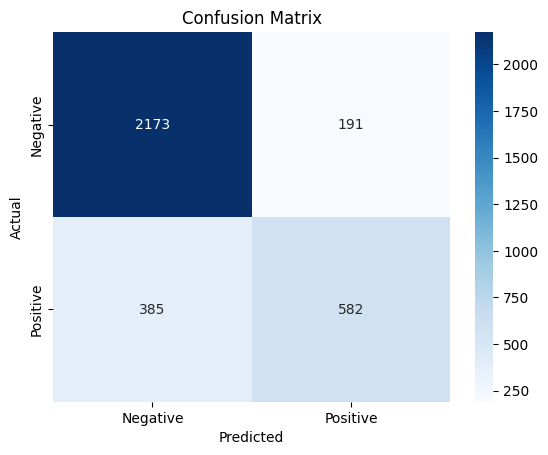

In [28]:
# Predict & confusion matrix
y_pred_prob = BILSTM_model.predict(x_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)
print()

# Classification report
print(classification_report(y_test, y_pred))
print()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Bi-LSTM Model Performance
train_acc_bilstm = history_bilstm.history['accuracy'][-1]
train_loss_bilstm = history_bilstm.history['loss'][-1]
val_acc_bilstm = history_bilstm.history['val_accuracy'][-1]
val_loss_bilstm = history_bilstm.history['val_loss'][-1]

print("\nBi-LSTM Model Performance:")
print(f"Train Accuracy: {train_acc_bilstm:.4f}")
print(f"Train Loss: {train_loss_bilstm:.4f}")
print(f"Validation Accuracy: {val_acc_bilstm:.4f}")
print(f"Validation Loss: {val_loss_bilstm:.4f}")


Bi-LSTM Model Performance:
Train Accuracy: 0.9182
Train Loss: 0.2385
Validation Accuracy: 0.8271
Validation Loss: 0.4511


3. Comparison

In [29]:
# Accuracy Graphs
def plot_accuracy(history_lstm, history_bilstm):
    plt.figure(figsize=(12, 6))

    # Plot LSTM accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
    plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
    plt.title('LSTM Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Bi-LSTM accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_bilstm.history['accuracy'], label='Train Accuracy')
    plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Bi-LSTM Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

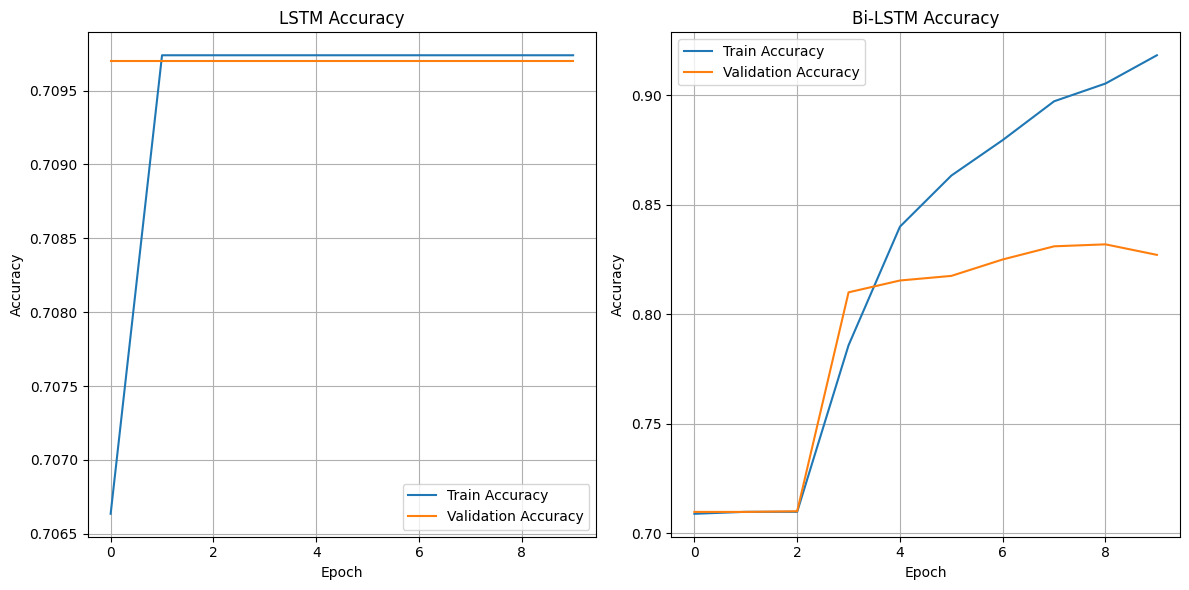

In [30]:
plot_accuracy(history_lstm, history_bilstm)